<a href="https://colab.research.google.com/github/uni-3/jupyter-notebooks/blob/master/%E6%99%82%E7%B3%BB%E5%88%97%E7%B7%B4%E7%BF%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## load from google drive

## 参考文献
解析方法
- https://logics-of-blue.com/python-time-series-analysis/
- http://www.procrasist.com/entry/12-time-series

ローカルのcsvファイルを使うとき
- https://colab.research.google.com/notebook#fileId=1JmwtF5OmSghC-y3-BkvxLan0zYXqCJJf


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!ls ./gdrive/'My Drive'/"Colab Notebooks"

## 時系列解析

In [0]:
# ライブラリを読み込む
import numpy as np
import pandas as pd
#from pandas.core import datetools as pd
from scipy import stats

from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline
# グラフを横長にする
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

# 統計モデル
import statsmodels.api as sm

import io

In [0]:
# 日付形式で読み込む（dtype=floatで読み込まないと、あとでARIMAモデル推定時にエラーとなる）
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
#data = pd.read_csv(io.StringIO(uploaded['AirPassengers.csv'].decode('utf-8')), index_col='Month', date_parser=dateparse, dtype='float')
data = pd.read_csv("./gdrive/My Drive/Colab Notebooks/AirPassengers.csv",
                   index_col='Month', parse_dates=True, dtype='float')

data.head()

,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


## 時系列データの取り扱い

In [0]:
# 日付を指定して値をとる
ts = data['#Passengers']
print("日付指定", ts['1949-01-01'])
 
# 1949年のデータをすべて取ってくる
print("1949年のデータ\n", ts['1949'])

日付指定 112.0
1949年のデータ
 Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
1949-06-01    135.0
1949-07-01    148.0
1949-08-01    148.0
1949-09-01    136.0
1949-10-01    119.0
1949-11-01    104.0
1949-12-01    118.0
Name: #Passengers, dtype: float64


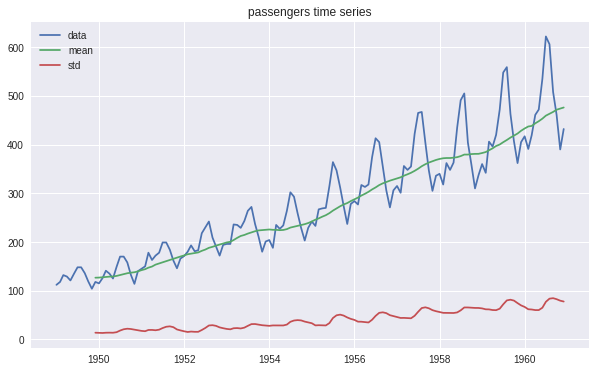

In [0]:
# plot
ts = data['#Passengers']

# 平均や分散が一定ならば定常と言える
rolmean = ts.rolling(window=12).mean()
rolstd = ts.rolling(window=12).std()

plt.plot(ts, label="data")
plt.plot(rolmean, label="mean")
plt.plot(rolstd, label="std")
plt.title("passengers time series")
plt.legend()

## 差分の取得

In [0]:
# シフトとは、データを下に1個ずらすこと、差分データを取るための前処理的な意味がある
# 前月と比べてどれだけ増えたかがわかる
ts.shift().head()

Month
1949-01-01      NaN
1949-02-01    112.0
1949-03-01    118.0
1949-04-01    132.0
1949-05-01    129.0
Name: #Passengers, dtype: float64

In [0]:
# 差分をとる
diff = ts - ts.shift()
diff.head()
# こちらでも同じ意味
# ts.diff().head()

Month
1949-01-01     NaN
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
Name: #Passengers, dtype: float64

In [0]:
# 対数とって差分をだす。これで数の増加を緩和させたりできる
# 変動率で計算する時は使いがち。モデルに当てはめる時も対数をとったら当てはまりやすくなるかも
logDiff = np.log(ts) - np.log(ts.shift())
# Nanを無くしても良い
logDiff.dropna()

## 自己相関係数の推定


In [0]:
# 自己相関を求める
# 前期と今期がどれだけ似ているかを表す
# + ならば先月と今月が正の相関を持つ
# - ならば先月と今月が負の相関を持つ
ts_acf = sm.tsa.stattools.acf(ts, nlags=40)
ts_acf

# 偏自己相関
# 特定の日のみとの自己相関が見たいとき
ts_pacf = sm.tsa.stattools.pacf(ts, nlags=40, method='ols')
ts_pacf

array([ 1.        ,  0.95893198, -0.32983096,  0.2018249 ,  0.14500798,
        0.25848232, -0.02690283,  0.20433019,  0.15607896,  0.56860841,
        0.29256358,  0.8402143 ,  0.61268285, -0.66597616, -0.38463943,
        0.0787466 , -0.02663483, -0.05805221, -0.04350748,  0.27732556,
       -0.04046447,  0.13739883,  0.3859958 ,  0.24203808, -0.04912986,
       -0.19599778, -0.15443575,  0.04484465,  0.18371541, -0.0906113 ,
       -0.06202938,  0.34827092,  0.09899499, -0.08396793,  0.36328898,
       -0.17956662,  0.15839435,  0.06376775, -0.27503705,  0.2707607 ,
        0.32002003])

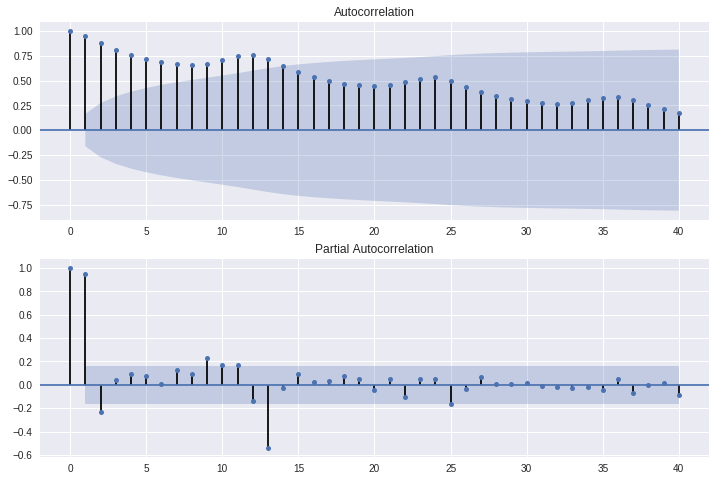

In [0]:
# 自己相関と偏自己相関のグラフ
# lags = いくつ前まで差分を取るか。グラフの横軸、n周期で相関が高いかわかる
# グラフより12（1年）周期で相関が高そう
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags=40, ax=ax2)

## ARIMAモデルの推定

In [0]:
# Iの部分、すなわち差分をあらかじめとっておく（引数なしの場合は１個前の差分という意味）
diff = ts - ts.shift()
diff = diff.dropna()
 
# 差分系列への自動ARMA推定関数の実行
resDiff = sm.tsa.arma_order_select_ic(diff, ic='aic', trend='nc')
resDiff

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


{'aic':              0            1            2
 0          NaN  1397.257791  1397.093436
 1  1401.852641  1412.615224  1385.496795
 2  1396.587654  1378.338024  1353.175673
 3  1395.021214  1379.614000  1351.138721
 4  1388.216680  1379.616584  1373.560615, 'aic_min_order': (3, 2)}

In [0]:
# P-3, q=2 が最善となったので、それをモデル化
from statsmodels.tsa.arima_model import ARIMA
ARIMA_3_1_2 = ARIMA(ts, order=(3, 1, 2)).fit(dist=False)
ARIMA_3_1_2.params

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


const                  2.673491
ar.L1.D.#Passengers    0.261982
ar.L2.D.#Passengers    0.367839
ar.L3.D.#Passengers   -0.363460
ma.L1.D.#Passengers   -0.075039
ma.L2.D.#Passengers   -0.924839
dtype: float64

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


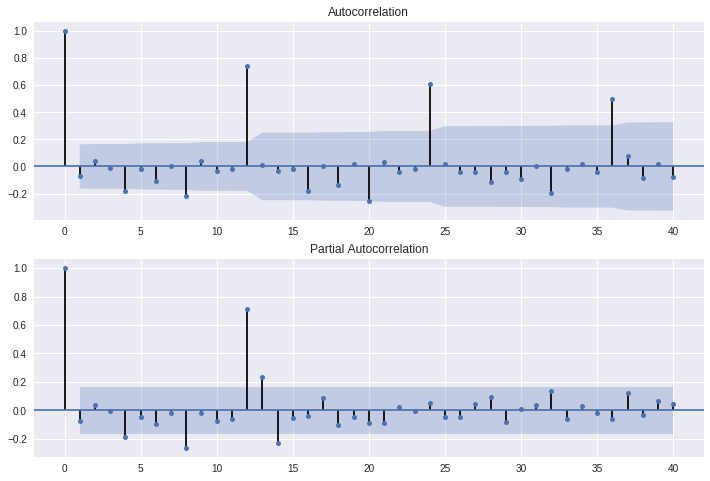

In [0]:
# 残差のチェック
# 周期性が残ってしまっている?
resid = ARIMA_3_1_2.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


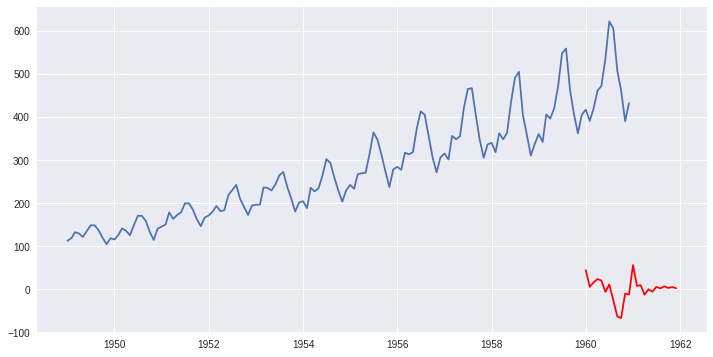

In [0]:
# 予測
pred = ARIMA_3_1_2.predict('1960-01-01', '1961-12-01')

# 実データと予測結果の図示
plt.plot(ts)
plt.plot(pred, "r")

In [0]:
# SARIMAモデルを「決め打ち」で推定する
import statsmodels.api as sm

SARIMA_3_1_2_111 = sm.tsa.SARIMAX(ts, order=(3,1,2), seasonal_order=(1,1,1,12)).fit()
print(SARIMA_3_1_2_111.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        #Passengers   No. Observations:                  144
Model:             SARIMAX(3, 1, 2)x(1, 1, 1, 12)   Log Likelihood                -502.994
Date:                            Sun, 17 Feb 2019   AIC                           1021.987
Time:                                    14:45:49   BIC                           1045.746
Sample:                                01-01-1949   HQIC                          1031.641
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5250      1.690      0.311      0.756      -2.788       3.838
ar.L2          0.2892      0.979   

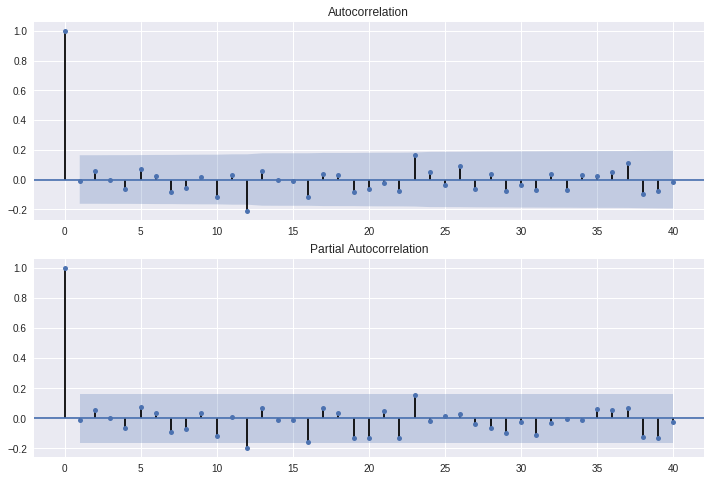

In [0]:
# 残差のチェック
residSARIMA = SARIMA_3_1_2_111.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=40, ax=ax2)

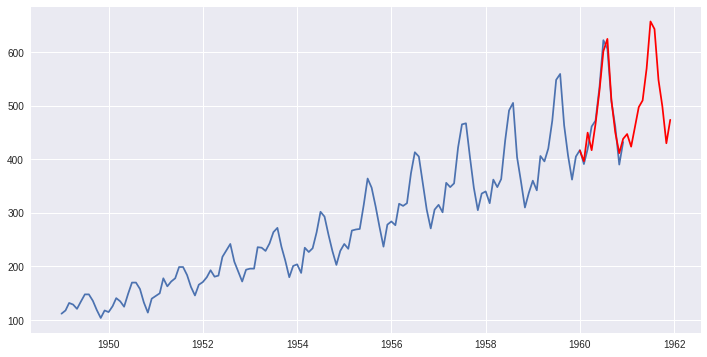

In [0]:
# 予測
pred = SARIMA_3_1_2_111.predict('1960-01-01', '1961-12-01')

# 実データと予測結果の図示
plt.plot(ts)
plt.plot(pred, "r")

## 時系列解析2
https://www.procrasist.com/entry/12-time-series

### 定常性の確認

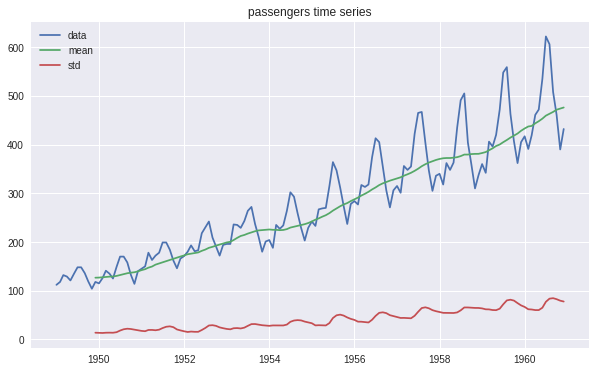

In [0]:
# plot
ts = data['#Passengers']

# 平均や分散が一定ならば定常と言える
rolmean = ts.rolling(window=12).mean()
rolstd = ts.rolling(window=12).std()

plt.plot(ts, label="data")
plt.plot(rolmean, label="mean")
plt.plot(rolstd, label="std")
plt.title("passengers time series")
plt.legend()

In [0]:
# 定常かどうか確認 DF検定？
from statsmodels.tsa.stattools import adfuller
adfuller(ts)

(0.815368879206047,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '10%': -2.578770059171598,
  '5%': -2.8840418343195267},
 996.6929308390189)

### 要因を減らして定常にしてやる

In [0]:
ts = data['#Passengers']
log_ts = np.log(ts)
log_mean = log_ts.rolling(window=12).mean()

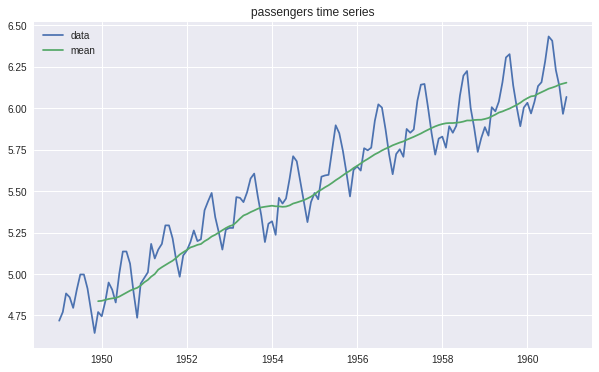

In [0]:
# plot
plt.plot(log_ts, label="data")
plt.plot(log_mean, label="mean")
plt.title("passengers time series")
plt.legend()

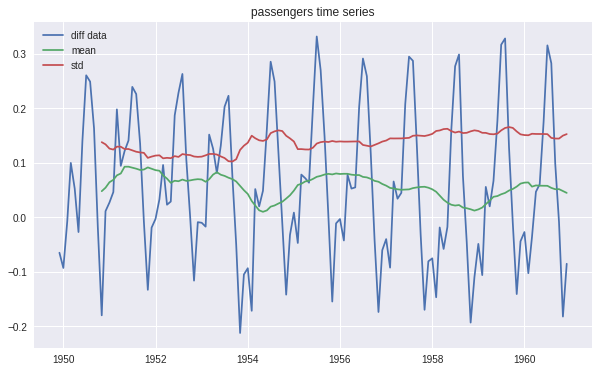

In [0]:
logDiff_mean = (log_ts - log_mean).dropna()
# log_meanを引いてやる（トレンドを成分をなくす）とmeanとstdの変動が小さくなる
plt.plot(logDiff_mean, label="diff data")
plt.plot(logDiff_mean.rolling(window=12).mean(), label="mean")
plt.plot(logDiff_mean.rolling(window=12).std(), label="std")
plt.title("passengers time series")
plt.legend()

In [0]:
# 定常かどうか確認 ADF検定？
# 単位根検定
def adf_test(data):
    result = sm.tsa.stattools.adfuller(data, autolag='AIC')
    output = pd.Series(result[0:4], index=['Test Statistic', 'p-value',
                                               '#Lags Used', 'Number of Observations Used'])
    for k, v in result[4].items():
        output['Critical Value ({})'.format(k)] = v
    return output


(-3.162907991300857,
 0.022234630001243903,
 13,
 119,
 {'1%': -3.4865346059036564,
  '10%': -2.579896092790057,
  '5%': -2.8861509858476264},
 -436.63269481747125)

In [0]:
# トレンドを消すと、定常になる
adf_test(logDiff_mean)